# Импортирование данных и библиотек

In [18]:
import numpy as np
import pandas as pd
import sys
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [ ]:
path_data = "/SODA/data/RNA/raw_data/processed/merged_data_hackaton_IB_GB_correct.csv" 
raw_counts = pd.read_csv(path_data, index_col=0)

df = pd.read_csv("/SODA/data/RNA/raw_data/processed/merged_data_hackaton_IB_GB.csv")

In [ ]:
print("Number of genes:", raw_counts.shape[0])
print("Number of samples:", raw_counts.shape[1])

фильтрация и убор ненужных генов (с 0 экспрессией)

In [40]:
raw_counts = raw_counts.loc[~(raw_counts==0).all(axis=1)]
raw_counts.shape

(1145, 4588)

sample discription

In [5]:
path_meta = "/SODA/data/RNA/raw_data/processed/meta_data_correct.csv" 
meta = pd.read_csv(path_meta, index_col=0)
meta = meta.drop(columns=['sex'])
meta.head(10)
meta.shape

(4588, 2)

To perform further analysis we will divide samples into age groups with a step = 10 years.

In [43]:
df = pd.DataFrame(pd.cut(meta["age"], np.arange(0, max(meta.age.values)+10, 10), right = False, ordered = True))
df.columns = ['AgeBins']
df['AgeBins'] = df['AgeBins'].astype(str)
meta = pd.concat([meta, df], axis=1)
meta = meta.replace(np.unique(meta['AgeBins'].values), np.arange(11))
meta['AgeRanges'] = df['AgeBins'].values.astype(str)

meta.reset_index(drop=True, inplace=True)
meta.index += 1
meta.head()

,GSE,GSM,age,AgeBins,AgeRanges
1,GSE16717,GSM418770,91,10,"[90, 100)"
2,GSE16717,GSM418771,56,6,"[50, 60)"
3,GSE16717,GSM418772,91,10,"[90, 100)"
4,GSE16717,GSM418773,52,6,"[50, 60)"
5,GSE16717,GSM418774,64,7,"[60, 70)"


## rpy2 функция

In [44]:
from rpy2 import robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects.numpy2ri
pandas2ri.activate()
robjects.numpy2ri.activate()
from rpy2.robjects.conversion import localconverter
from rpy2.rinterface_lib.embedded import RRuntimeError
from functions import DESeq2

In [47]:
deseq = importr('DESeq2')
sumexp = importr('SummarizedExperiment')
degreport = importr('DEGreport')

In [ ]:
to_dataframe = robjects.r("function(x) data.frame(x)")
get_clusters = robjects.r("function(x) x[['df']]")
get_cluster_data = robjects.r("function(x) x[['normalized']]")
to_factors = robjects.r("function(x) data.frame(lapply(x,factor))")

# Нормализация данных методом rpy2

In [13]:
meta.head(2)

,GSM,age,AgeBins,AgeRanges
1,GSM418770,91,10,"[90, 100)"
2,GSM418771,56,6,"[50, 60)"


In [14]:
raw_counts[raw_counts < 0] = np.nan 

min_positive_value = np.nanmin(raw_counts[raw_counts > 0])
raw_counts[np.isnan(raw_counts)] = min_positive_value

In [15]:
design = Formula("~AgeBins")
d = DESeq2(raw_counts, meta, design)


In [16]:
print(meta.dtypes)

GSM          object
age           int64
AgeBins       int64
AgeRanges    object
dtype: object


In [17]:
d.create_deseq_object()

In [18]:
print("Размерность meta:", meta.shape)
print("Размерность raw_data:", raw_counts.shape)

Размерность meta: (4588, 4)
Размерность raw_data: (1145, 4588)


In [19]:
ncounts = d.normalization()

In [ ]:
vst_mat = d.transformation(method = "vst")

# PCA анализ

In [22]:
x = np.transpose(vst_mat.values)
x = StandardScaler().fit_transform(x)

In [23]:
pca = PCA(n_components=2)

In [24]:
principalComponents = pca.fit_transform(x)

In [25]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [26]:
pcdf = pd.concat([principalDf.set_index(meta.index), meta], axis = 1)

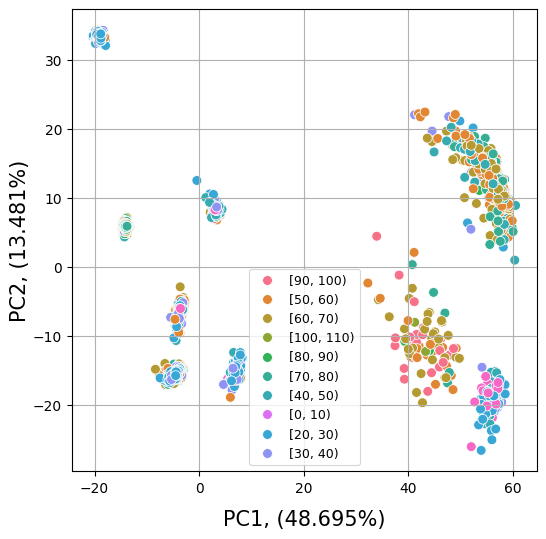

In [27]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_context("paper", font_scale=1.5)
sns.scatterplot(data=pcdf, x="PC1", y="PC2", hue="AgeRanges", s = 50)
plt.legend(loc="upper right", fontsize=5)

var_pc1 = (pca.explained_variance_ratio_[0]*100).round(3)
var_pc2 = (pca.explained_variance_ratio_[1]*100).round(3)
plt.xlabel('PC1, ('+ var_pc1.astype(str) + "%)", fontsize = 15, labelpad = 10)
plt.ylabel('PC2, ('+ var_pc2.astype(str) + "%)", fontsize = 15, labelpad = 2)

handles, labels = plt.gca().get_legend_handles_labels()

order = [0,1,2,3,4,5,6,9,7,8]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=9)

ax.grid()

# Нормалищации данных методом Combat

In [21]:
path_data = "/SODA/data/RNA/raw_data/processed/merged_data_hackaton_IB_GB_correct.csv" 
raw_counts = pd.read_csv(path_data, index_col=0)

In [22]:
#path_meta = "/SODA/data/RNA/raw_data/processed/merged_data_annotation_full.csv"
path_meta = "/SODA/data/RNA/raw_data/processed/meta_data_correct.csv"
meta = pd.read_csv(path_meta, index_col=0)
#meta = meta.drop(columns=['sex'])
meta.head(2)

,GSE,GSM,age,sex
1,GSE16717,GSM418770,91,F
2,GSE16717,GSM418771,56,F


In [23]:
meta.reset_index(inplace=True)
print(meta.head())

   index       GSE        GSM  age sex
0      1  GSE16717  GSM418770   91   F
1      2  GSE16717  GSM418771   56   F
2      3  GSE16717  GSM418772   91   M
3      4  GSE16717  GSM418773   52   M
4      5  GSE16717  GSM418774   64   F


In [24]:
num_unique_gse = meta['GSE'].nunique()

print("Количество уникальных значений GSE:", num_unique_gse)

Количество уникальных значений GSE: 9


In [25]:
gsm_lists = []

for gse_value in meta['GSE'].unique():
    gsm_values = meta.loc[meta['GSE'] == gse_value, 'GSM'].tolist()
    gsm_values_cleaned = [gsm.replace('"', '') for gsm in gsm_values]
    gsm_lists.append(gsm_values_cleaned)

for i, gsm_list in enumerate(gsm_lists):
    print(f"list {i+1}: {gsm_list}")

list 1: ['GSM418770', 'GSM418771', 'GSM418772', 'GSM418773', 'GSM418774', 'GSM418775', 'GSM418776', 'GSM418777', 'GSM418778', 'GSM418779', 'GSM418780', 'GSM418781', 'GSM418782', 'GSM418783', 'GSM418784', 'GSM418785', 'GSM418786', 'GSM418787', 'GSM418788', 'GSM418789', 'GSM418790', 'GSM418791', 'GSM418792', 'GSM418793', 'GSM418794', 'GSM418795', 'GSM418796', 'GSM418797', 'GSM418798', 'GSM418799', 'GSM418800', 'GSM418801', 'GSM418802', 'GSM418803', 'GSM418804', 'GSM418805', 'GSM418806', 'GSM418807', 'GSM418808', 'GSM418809', 'GSM418810', 'GSM418811', 'GSM418812', 'GSM418813', 'GSM418814', 'GSM418815', 'GSM418816', 'GSM418817', 'GSM418818', 'GSM418819', 'GSM418820', 'GSM418821', 'GSM418822', 'GSM418823', 'GSM418824', 'GSM418825', 'GSM418826', 'GSM418827', 'GSM418828', 'GSM418829', 'GSM418830', 'GSM418831', 'GSM418832', 'GSM418833', 'GSM418834', 'GSM418835', 'GSM418836', 'GSM418837', 'GSM418838', 'GSM418839', 'GSM418840', 'GSM418841', 'GSM418842', 'GSM418843', 'GSM418844', 'GSM418845', 'GS

In [26]:
dfs_from_raw_counts = []

for gsm_list in gsm_lists:
    df = raw_counts[gsm_list].copy()
    df.index = raw_counts.index
    dfs_from_raw_counts.append(df)

for i, df in enumerate(dfs_from_raw_counts):
    print(f"DataFrame {i+1}:")
    print(df.head())

DataFrame 1:
        GSM418770  GSM418771  GSM418772  GSM418773  GSM418774  GSM418775  \
ID_REF                                                                     
AAAS     3.064417   3.328753   1.372572   1.637705   1.527834   2.951874   
ABCB6    3.346645  -0.231760   3.509782   5.184210   3.099496   3.803792   
ABCC5    3.262218   2.422083   1.243954   4.207445   2.763153   3.382930   
ABCC9    8.961700   8.756902   8.830115   8.759860   8.912963   8.654949   
ABCE1    3.727037   4.527301   3.153020   4.219602   4.174053   4.377510   

        GSM418776  GSM418777  GSM418778  GSM418779  ...  GSM418910  GSM418911  \
ID_REF                                              ...                         
AAAS     3.880844   2.769172   2.499050   2.718532  ...   3.679222   4.072074   
ABCB6    3.008164   1.900526   3.667140   3.687952  ...   2.458360   2.348010   
ABCC5    3.173870   3.737788   2.688748   2.903328  ...   2.582896   4.136665   
ABCC9    9.315765   9.463350   9.046299   8.82762

In [27]:
from combat.pycombat import pycombat
import pandas as pd
import matplotlib.pyplot as plt

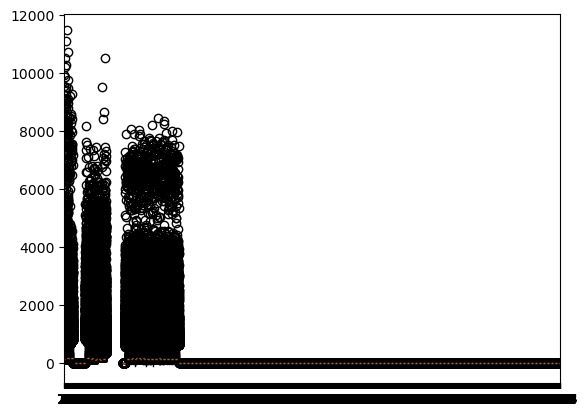

In [28]:
# plot raw data
plt.boxplot(raw_counts)
plt.show()

In [29]:
print(raw_counts.head(2))

        GSM755408  GSM755409  GSM755410  GSM755411  GSM755412  GSM755413  \
ID_REF                                                                     
AAAS       107.13     141.43     110.76     104.29     122.89     143.00   
ABCB6      178.88     205.01     238.25     192.41     180.63     157.92   

        GSM755414  GSM755415  GSM755416  GSM755417  ...  GSM1611025  \
ID_REF                                              ...               
AAAS       214.07     154.25     200.58     204.84  ...    7.485761   
ABCB6      168.63     179.03     177.52     162.53  ...    7.590791   

        GSM1611026  GSM1611027  GSM1611028  GSM1611029  GSM1611030  \
ID_REF                                                               
AAAS      7.447453    7.214917    7.415127    7.577271    7.099415   
ABCB6     7.752747    7.545686    7.513859    7.617985    7.560340   

        GSM1611031  GSM1611032  GSM1611033  GSM1611034  
ID_REF                                                  
AAAS      7.455

Found 9 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


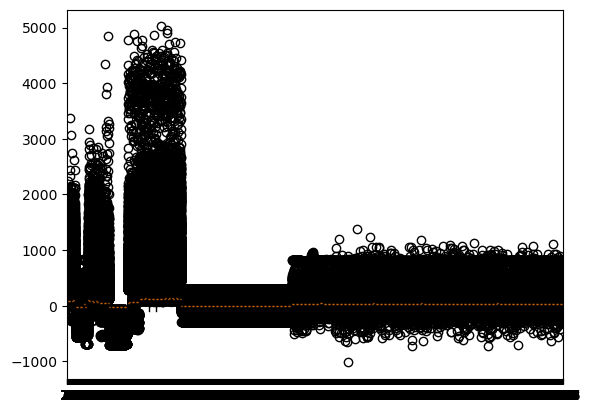

In [30]:
raw_counts_filled = raw_counts.fillna(0)

dfs_from_raw_counts_filled = [df.fillna(0) for df in dfs_from_raw_counts]

datasets = []

datasets.extend(dfs_from_raw_counts_filled)

batch = []

for j in range(len(datasets)):
    batch.extend([j for _ in range(len(datasets[j].columns))])

df_corrected = pycombat(raw_counts_filled, batch)

# Визуализируем результаты
plt.boxplot(df_corrected)
plt.show()

In [17]:
#df_corrected.to_csv("correct_data/merged_data_hackaton_IB_GB_Combat.csv", index=False)

# PCA анализ нормализации 

In [50]:
meta.head(2)

,GSE,GSM,age,AgeBins,AgeRanges
1,GSE16717,GSM418770,91,10,"[90, 100)"
2,GSE16717,GSM418771,56,6,"[50, 60)"


In [78]:
df_corrected[df_corrected < 0] = np.nan  # Заменить отрицательные значения на NaN

min_positive_value = np.nanmin(df_corrected[df_corrected > 0])
df_corrected[np.isnan(df_corrected)] = min_positive_value

In [79]:
design = Formula("~AgeBins")
d = DESeq2(df_corrected, meta, design)

In [80]:
print(meta.dtypes)

GSE          object
GSM          object
age           int64
AgeBins       int64
AgeRanges    object
dtype: object


In [81]:
d.create_deseq_object()

In [82]:
print("Размерность meta:", meta.shape)
print("Размерность raw_data:", df_corrected.shape)

Размерность meta: (4588, 5)
Размерность raw_data: (1145, 4588)


In [83]:
ncounts = d.normalization()

In [ ]:
vst_mat = d.transformation(method = "vst")

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [85]:
x = np.transpose(vst_mat.values)
x = StandardScaler().fit_transform(x)

In [86]:
pca = PCA(n_components=2)

In [87]:
principalComponents = pca.fit_transform(x)

In [88]:
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])

In [89]:
pcdf = pd.concat([principalDf.set_index(meta.index), meta], axis = 1)

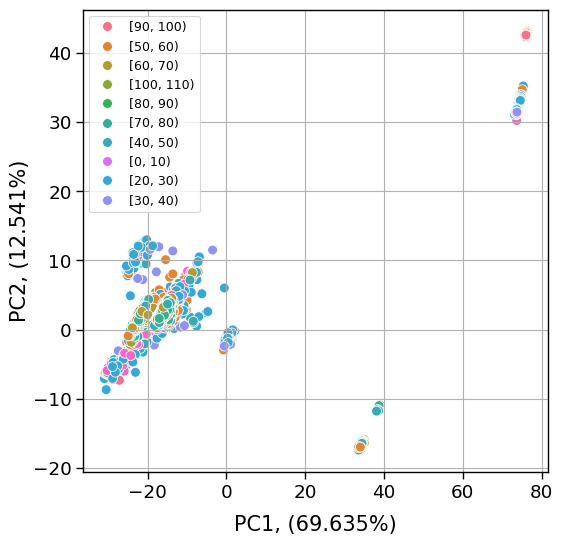

In [90]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.set_context("paper", font_scale=1.5)
sns.scatterplot(data=pcdf, x="PC1", y="PC2", hue="AgeRanges", s = 50)
plt.legend(loc="upper right", fontsize=5)

var_pc1 = (pca.explained_variance_ratio_[0]*100).round(3)
var_pc2 = (pca.explained_variance_ratio_[1]*100).round(3)
plt.xlabel('PC1, ('+ var_pc1.astype(str) + "%)", fontsize = 15, labelpad = 10)
plt.ylabel('PC2, ('+ var_pc2.astype(str) + "%)", fontsize = 15, labelpad = 2)

handles, labels = plt.gca().get_legend_handles_labels()

order = [0,1,2,3,4,5,6,9,7,8]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=9)

ax.grid()

# Проверки разных вариантов объединения поддатасетов и их нормализация методом Combat

In [31]:
raw_counts_filled = raw_counts.fillna(0)

dfs_from_raw_counts_filled = [df.fillna(0) for df in dfs_from_raw_counts]

### Поддатасеты 1 и 2 

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


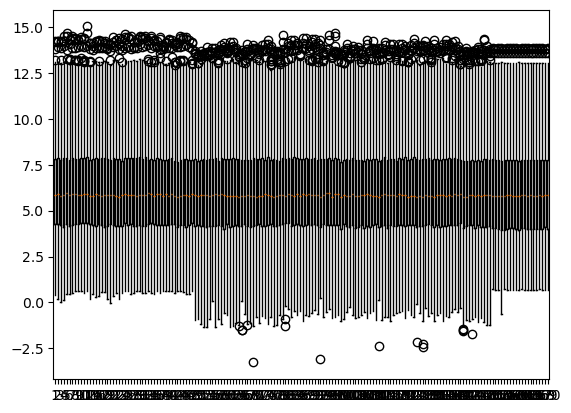

In [14]:
combined_dataset_1_2 = pd.concat([datasets[0], datasets[1]], axis=1)

batch_combined_1_2 = [0] * len(datasets[0].columns) + [1] * len(datasets[1].columns)

df_corrected_combined_1_2 = pycombat(combined_dataset_1_2.fillna(0), batch_combined_1_2)

plt.boxplot(df_corrected_combined_1_2)
plt.show()

### Поддатасеты 2 и 3

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


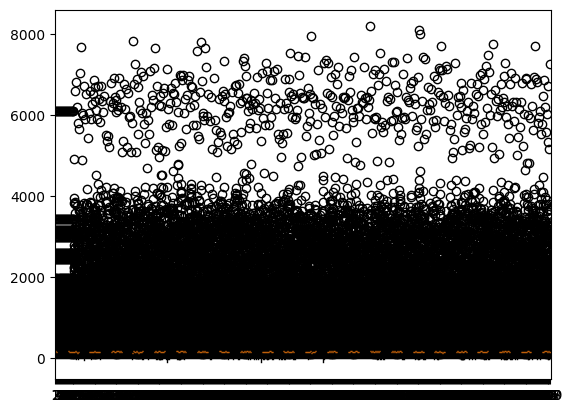

In [17]:
combined_dataset_2_3 = pd.concat([datasets[1], datasets[2]], axis=1)

batch_combined_2_3 = [0] * len(datasets[1].columns) + [1] * len(datasets[2].columns)

df_corrected_combined_2_3 = pycombat(combined_dataset_2_3.fillna(0), batch_combined_2_3)

plt.boxplot(df_corrected_combined_2_3)
plt.show()


### Поддатасеты 3 и 4

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


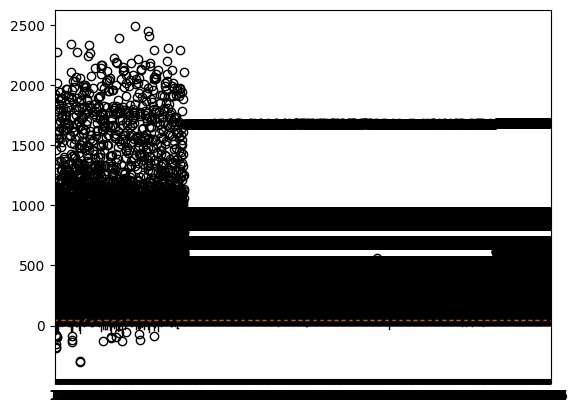

In [18]:
combined_dataset_3_4 = pd.concat([datasets[2], datasets[3]], axis=1)

batch_combined_3_4 = [0] * len(datasets[2].columns) + [1] * len(datasets[3].columns)

df_corrected_combined_3_4 = pycombat(combined_dataset_3_4.fillna(0), batch_combined_3_4)

plt.boxplot(df_corrected_combined_3_4)
plt.show()


### Поддатасеты 4 и 5 

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


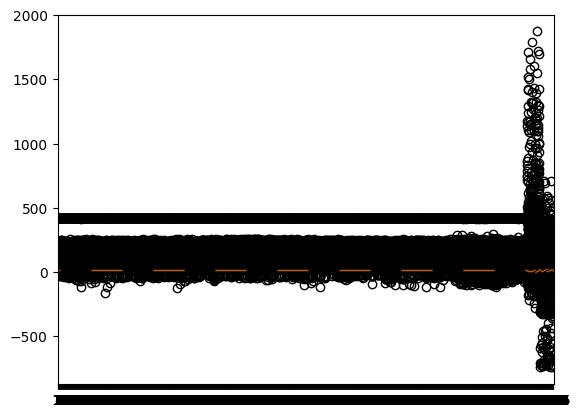

In [19]:
combined_dataset_4_5 = pd.concat([datasets[3], datasets[4]], axis=1)

batch_combined_4_5 = [0] * len(datasets[3].columns) + [1] * len(datasets[4].columns)

df_corrected_combined_4_5 = pycombat(combined_dataset_4_5.fillna(0), batch_combined_4_5)

plt.boxplot(df_corrected_combined_4_5)
plt.show()


### Поддатасеты 4 и 6

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


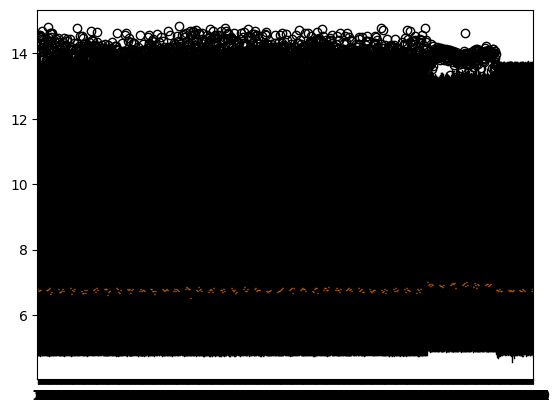

In [20]:
combined_dataset_4_6 = pd.concat([datasets[3], datasets[5]], axis=1)

batch_combined_4_6 = [0] * len(datasets[3].columns) + [1] * len(datasets[5].columns)

df_corrected_combined_4_6 = pycombat(combined_dataset_4_6.fillna(0), batch_combined_4_6)

plt.boxplot(df_corrected_combined_4_6)
plt.show()

### Поддатасеты 6 и 7

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


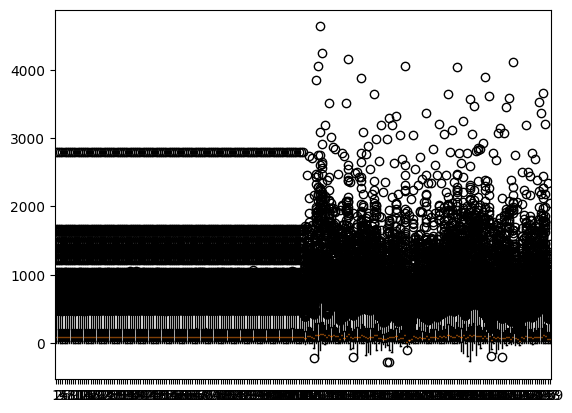

In [21]:
combined_dataset_6_7 = pd.concat([datasets[5], datasets[6]], axis=1)

batch_combined_6_7 = [0] * len(datasets[5].columns) + [1] * len(datasets[6].columns)

df_corrected_combined_6_7 = pycombat(combined_dataset_6_7.fillna(0), batch_combined_6_7)

plt.boxplot(df_corrected_combined_6_7)
plt.show()

### Поддатасеты 6 и 8 

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


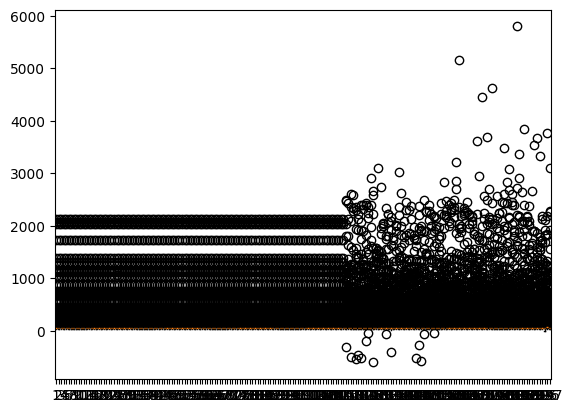

In [23]:
combined_dataset_6_8 = pd.concat([datasets[5], datasets[7]], axis=1)

batch_combined_6_8 = [0] * len(datasets[5].columns) + [1] * len(datasets[7].columns)

df_corrected_combined_6_8 = pycombat(combined_dataset_6_8.fillna(0), batch_combined_6_8)

plt.boxplot(df_corrected_combined_6_8)
plt.show()

### Поддатасеты 6 и 9

Found 2 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


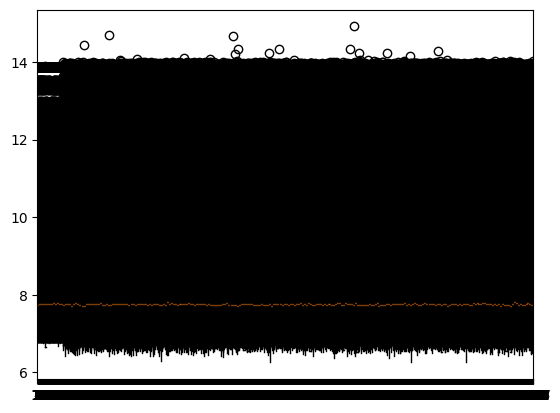

In [25]:
combined_dataset_6_9 = pd.concat([datasets[5], datasets[8]], axis=1)

batch_combined_6_9 = [0] * len(datasets[5].columns) + [1] * len(datasets[8].columns)

df_corrected_combined_6_9 = pycombat(combined_dataset_6_9.fillna(0), batch_combined_6_9)

plt.boxplot(df_corrected_combined_6_9)
plt.show()

### Поддатасеты 1 2 4 6 9 

Found 5 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


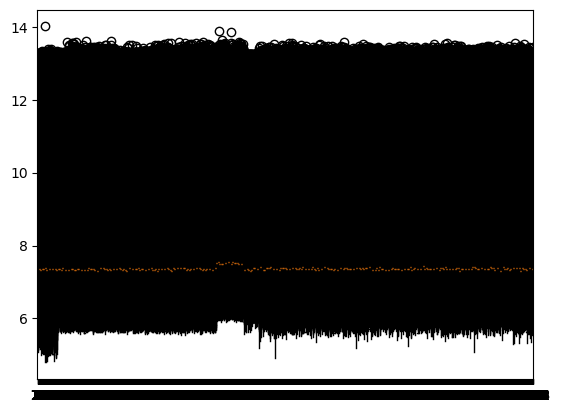

In [18]:
combined_dataset_1_2_4_6_9 = pd.concat([datasets[0], datasets[1], datasets[3], datasets[5], datasets[8]], axis=1)

batch_combined_1_2_4_6_9 = [0] * len(datasets[0].columns) + [1] * len(datasets[1].columns) + [2] * len(datasets[3].columns) + [3] * len(datasets[5].columns) + [4] * len(datasets[8].columns)

df_corrected_combined_1_2_4_6_9 = pycombat(combined_dataset_1_2_4_6_9.fillna(0), batch_combined_1_2_4_6_9)

plt.boxplot(df_corrected_combined_1_2_4_6_9)
plt.show()


### Поддатасеты 1 2 6 9

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


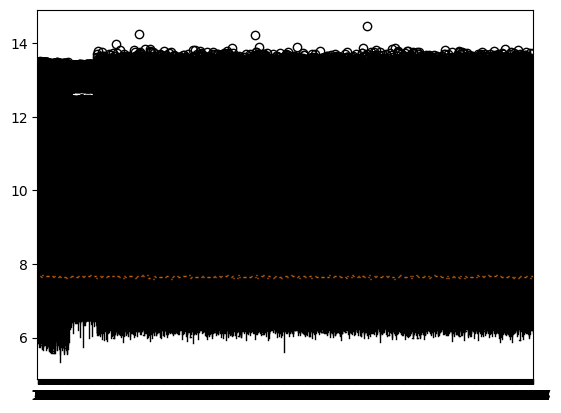

In [44]:
combined_dataset_1_2_6_9 = pd.concat([datasets[0], datasets[1], datasets[5], datasets[8]], axis=1)

batch_combined_1_2_6_9 = [0] * len(datasets[0].columns) + [1] * len(datasets[1].columns) + [2] * len(datasets[5].columns) + [3] * len(datasets[8].columns)

df_corrected_combined_1_2_6_9 = pycombat(combined_dataset_1_2_6_9.fillna(0), batch_combined_1_2_6_9)

plt.boxplot(df_corrected_combined_1_2_6_9)
plt.show()

In [45]:
df_corrected_combined_1_2_6_9.head()

,GSM418770,GSM418771,GSM418772,GSM418773,GSM418774,GSM418775,GSM418776,GSM418777,GSM418778,GSM418779,...,GSM1611025,GSM1611026,GSM1611027,GSM1611028,GSM1611029,GSM1611030,GSM1611031,GSM1611032,GSM1611033,GSM1611034
ID_REF,,,,,,,,,,,,,,,,,,,,,
AAAS,7.099390,7.175374,6.613064,6.689277,6.657695,7.067039,7.334075,7.014521,6.936874,6.999964,...,7.466477,7.386065,6.897951,7.318210,7.658564,6.655502,7.402690,7.301606,6.986405,7.114825
ABCB6,7.372061,6.517465,7.411021,7.810908,7.313037,7.481237,7.291225,7.026698,7.448601,7.453572,...,7.186526,7.460138,7.110324,7.056555,7.232468,7.135081,6.975251,7.037687,6.962817,6.972881
ABCC5,8.302909,8.129885,7.887250,8.497578,8.200127,8.327770,8.284714,8.400853,8.184804,8.228996,...,8.268879,8.486585,8.412103,8.316129,8.385869,8.266484,8.222472,8.373245,8.304688,8.266443
ABCC9,6.940537,6.934208,6.936470,6.934299,6.939030,6.931057,6.951478,6.956039,6.943151,6.936393,...,6.924645,7.164590,7.048865,6.843959,6.858866,6.910659,6.840281,6.760037,6.984461,7.029883
ABCE1,6.954685,7.117040,6.838230,7.054615,7.045374,7.086651,6.971618,7.048987,7.204513,6.845344,...,6.888039,6.983614,7.092766,7.009460,6.756384,6.934222,6.521021,7.140047,7.015986,6.972625


In [46]:
import pandas as pd
import numpy as np

df_corrected_combined_1_2_6_9 = pd.DataFrame(df_corrected_combined_1_2_6_9)
mean_value = df_corrected_combined_1_2_6_9.values.mean()
median_value = np.median(df_corrected_combined_1_2_6_9.values)
sd_value = df_corrected_combined_1_2_6_9.values.std()
variance_value = df_corrected_combined_1_2_6_9.values.var()
min_value = df_corrected_combined_1_2_6_9.values.min()
max_value = df_corrected_combined_1_2_6_9.values.max()
quartiles = df_corrected_combined_1_2_6_9.quantile([0.25, 0.75])
range_value = max_value - min_value
#Coefficient of Variation
cv_value = sd_value / mean_value * 100
result = pd.DataFrame({'mean': [mean_value], 'median': [median_value], 'sd': [sd_value], 'variance': [variance_value],
                       'min': [min_value], 'max': [max_value], 'Q1': [quartiles.iloc[0]], 'Q3': [quartiles.iloc[1]],
                       'range': [range_value], 'cv': [cv_value]})
print(result)

       mean    median        sd  variance       min        max  \
0  8.076299  7.657458  1.308157  1.711275  5.323809  14.452731   

                                                  Q1  \
0  GSM418770     7.079843
GSM418771     7.079007
...   

                                                  Q3     range         cv  
0  GSM418770     8.826772
GSM418771     8.822485
...  9.128922  16.197485  


### Поддатасеты 3 7 8 5

Found 4 batches.
Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


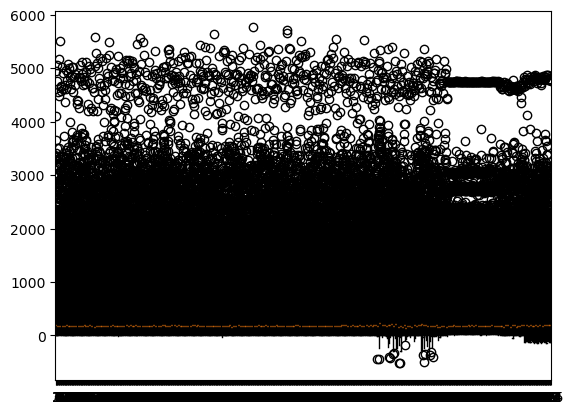

In [34]:
combined_dataset_3_7_8_5 = pd.concat([datasets[2], datasets[6], datasets[7], datasets[4]], axis=1)

batch_combined_3_7_8_5 = [0] * len(datasets[2].columns) + [1] * len(datasets[6].columns) + [2] * len(datasets[7].columns) + [3] * len(datasets[4].columns)

df_corrected_combined_3_7_8_5 = pycombat(combined_dataset_3_7_8_5.fillna(0), batch_combined_3_7_8_5)

plt.boxplot(df_corrected_combined_3_7_8_5)
plt.show()

In [35]:
df_corrected_combined_3_7_8_5.head()

,GSM1350856,GSM1350857,GSM1350858,GSM1350859,GSM1350860,GSM1350861,GSM1350862,GSM1350863,GSM1350864,GSM1350865,...,GSM755478,GSM755479,GSM755480,GSM755481,GSM755482,GSM755483,GSM755484,GSM755485,GSM755486,GSM755487
ID_REF,,,,,,,,,,,,,,,,,,,,,
AAAS,326.016479,560.504549,374.207203,543.951306,257.206450,432.065194,411.710653,361.005942,303.413139,447.928697,...,397.336015,415.111584,500.032930,459.881807,437.780212,442.641416,394.883114,434.435347,400.910242,404.599151
ABCB6,93.691164,88.922989,91.967985,90.970169,96.941811,97.332480,92.056579,97.214265,87.342064,105.935637,...,92.469250,93.139684,92.076399,91.367151,92.626861,91.675315,91.738830,95.234496,93.823056,94.620520
ABCC5,137.642947,111.263560,120.442872,88.974578,128.379222,152.413893,142.404538,127.871100,127.097393,112.781892,...,144.201368,155.333467,161.955600,158.050722,139.417046,134.358367,149.402862,149.650910,136.402885,131.806478
ABCC9,27.126609,28.738797,27.851002,29.452756,31.567721,27.847905,30.194220,29.056383,28.222821,28.671622,...,28.517852,29.267754,28.229914,28.040065,28.770983,28.916534,28.989310,28.726685,29.514558,29.375335
ABCE1,374.708282,413.732991,454.102141,134.278846,286.114260,434.739165,422.700544,374.849451,219.291095,233.138671,...,329.610269,369.371750,456.639486,445.551303,401.632600,330.485117,369.988891,354.831649,316.290885,242.776566


In [38]:
df_corrected_combined_3_7_8_5 = pd.DataFrame(df_corrected_combined_3_7_8_5)
mean_value = df_corrected_combined_3_7_8_5.values.mean()
median_value = np.median(df_corrected_combined_3_7_8_5.values)
sd_value = df_corrected_combined_3_7_8_5.values.std()
variance_value = df_corrected_combined_3_7_8_5.values.var()
min_value = df_corrected_combined_3_7_8_5.values.min()
max_value = df_corrected_combined_3_7_8_5.values.max()
quartiles = df_corrected_combined_3_7_8_5.quantile([0.25, 0.75])
range_value = max_value - min_value
#Coefficient of Variation
cv_value = sd_value / mean_value * 100
result = pd.DataFrame({'mean': [mean_value], 'median': [median_value], 'sd': [sd_value], 'variance': [variance_value],
                       'min': [min_value], 'max': [max_value], 'Q1': [quartiles.iloc[0]], 'Q3': [quartiles.iloc[1]],
                       'range': [range_value], 'cv': [cv_value]})
print(result)

         mean     median          sd       variance         min         max  \
0  291.547525  182.55702  369.433954  136481.446626 -524.021181  5764.88335   

                                                  Q1  \
0  GSM1350856    92.402109
GSM1350857    89.72932...   

                                                  Q3        range          cv  
0  GSM1350856    369.477102
GSM1350857    366.773...  6288.904531  126.714831  


In [17]:
df_corrected_combined_3_7_8_5.to_csv('/SODA/data/RNA/processed/df_corrected_combined_3_7_8_5.csv')
#combined_dataset_3_7_8_5.to_csv('correct_data/combined_dataset_3_7_8_5.csv')

# Построение граффика распределения по значениям по разным датасетам 

## для 1 2 6 9 

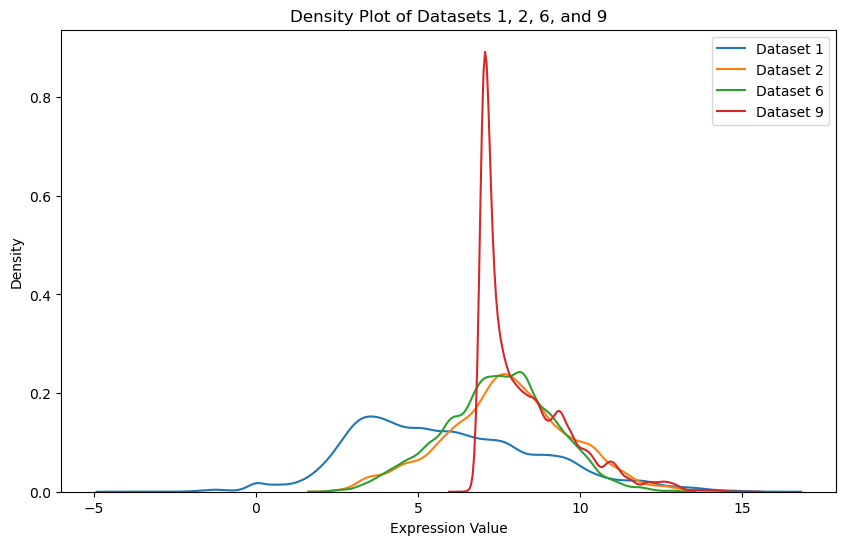

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

sns.kdeplot(datasets[0].values.flatten(), label='Dataset 1')
sns.kdeplot(datasets[1].values.flatten(), label='Dataset 2')
sns.kdeplot(datasets[5].values.flatten(), label='Dataset 6')
sns.kdeplot(datasets[8].values.flatten(), label='Dataset 9')

plt.xlabel('Expression Value')
plt.ylabel('Density')
plt.title('Density Plot of Datasets 1, 2, 6, and 9')

plt.legend()
plt.show()

In [48]:
datasets[8].head()

,GSM1608849,GSM1608850,GSM1608851,GSM1608852,GSM1608853,GSM1608854,GSM1608855,GSM1608856,GSM1608857,GSM1608858,...,GSM1611025,GSM1611026,GSM1611027,GSM1611028,GSM1611029,GSM1611030,GSM1611031,GSM1611032,GSM1611033,GSM1611034
ID_REF,,,,,,,,,,,,,,,,,,,,,
AAAS,7.352131,7.268778,7.187602,7.287063,7.329402,7.289843,7.280790,7.467384,7.403159,7.550349,...,7.485761,7.447453,7.214917,7.415127,7.577271,7.099415,7.455373,7.407217,7.257056,7.318235
ABCB6,7.496836,7.728098,7.446949,7.673014,7.372168,7.523338,7.535032,7.670370,7.779575,7.882557,...,7.590791,7.752747,7.545686,7.513859,7.617985,7.560340,7.465734,7.502691,7.458374,7.464331
ABCC5,8.921709,8.533844,8.505204,8.545925,8.714291,8.788567,8.736459,8.452094,8.846806,8.758718,...,8.710343,8.928464,8.853840,8.757683,8.827556,8.707943,8.663847,8.814908,8.746220,8.707902
ABCC9,7.018916,6.993094,6.845635,7.182149,6.992712,7.063281,7.083134,7.086391,6.988678,6.957307,...,6.981230,7.197422,7.093153,6.908532,6.921963,6.968629,6.905218,6.832918,7.035125,7.076050
ABCE1,7.159986,7.063609,7.182082,7.032359,6.960302,7.179380,7.098475,7.144213,7.023206,6.979337,...,7.082886,7.126500,7.176309,7.138294,7.022808,7.103961,6.915405,7.197885,7.141272,7.121485


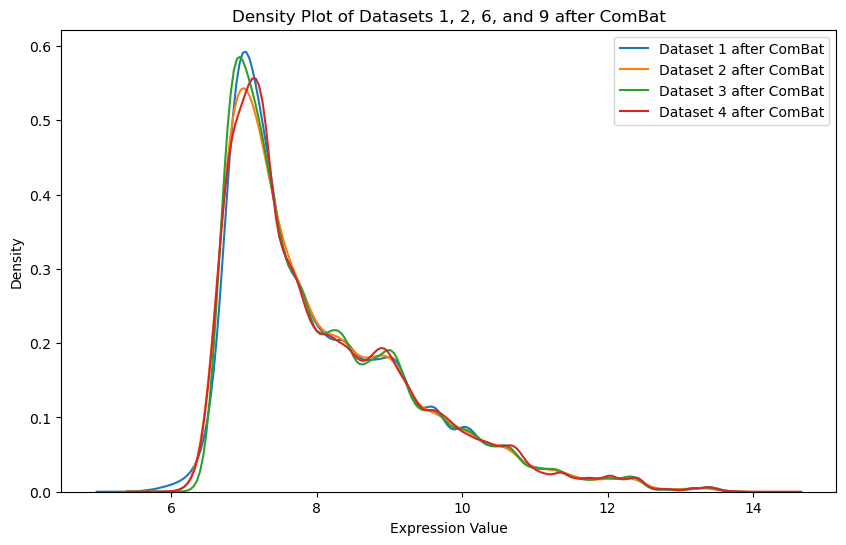

In [49]:
columns_1_2_6_9 = [datasets[i].columns[1:] for i in [0, 1, 5, 8]]

plt.figure(figsize=(10, 6))

datasets_corrected_1_2_6_9 = [df_corrected_combined_1_2_6_9.iloc[:, df_corrected_combined_1_2_6_9.columns.isin(columns)] for columns in columns_1_2_6_9]

for i, dataset_corrected in enumerate(datasets_corrected_1_2_6_9):
    sns.kdeplot(dataset_corrected.values.flatten(), label=f'Dataset {i+1} after ComBat')

plt.xlabel('Expression Value')
plt.ylabel('Density')
plt.title('Density Plot of Datasets 1, 2, 6, and 9 after ComBat')

plt.legend()

plt.show()


Теперь поглядим что там по разделению по полам

In [50]:
new_male_datasets = []
new_female_datasets = []

for dataset in datasets_corrected_1_2_6_9:
    male_dataset = pd.DataFrame(columns=dataset.columns)
    female_dataset = pd.DataFrame(columns=dataset.columns)

    column_names = dataset.columns[1:]  # Пропускаем первую колонку "ID_REF"

    for column in column_names:
        gsm_number = str(column.split('_')[-1])
        
        if (meta['GSM'] == gsm_number).any():
            gender = meta.loc[meta['GSM'] == gsm_number, 'sex'].iloc[0]

            if gender == 'M':
                male_dataset[column] = dataset[column]
            elif gender == 'F':
                female_dataset[column] = dataset[column]

    new_male_datasets.append(male_dataset)
    new_female_datasets.append(female_dataset)


In [51]:
print("Мужские датасеты:")
for i, dataset in enumerate(new_male_datasets, 1):
    print(f"Мужской датасет {i}:")
    print(dataset.head())

print("\nЖенские датасеты:")
for i, dataset in enumerate(new_female_datasets, 1):
    print(f"Женский датасет {i}:")
    print(dataset.head())


Мужские датасеты:
Мужской датасет 1:
       GSM418771  GSM418772  GSM418773 GSM418774  GSM418775  GSM418776  \
ID_REF                                                                   
AAAS         NaN   6.613064   6.689277       NaN   7.067039   7.334075   
ABCB6        NaN   7.411021   7.810908       NaN   7.481237   7.291225   
ABCC5        NaN   7.887250   8.497578       NaN   8.327770   8.284714   
ABCC9        NaN   6.936470   6.934299       NaN   6.931057   6.951478   
ABCE1        NaN   6.838230   7.054615       NaN   7.086651   6.971618   

       GSM418777  GSM418778  GSM418779  GSM418780  ... GSM418910 GSM418911  \
ID_REF                                             ...                       
AAAS         NaN   6.936874   6.999964   7.381641  ...  7.276118       NaN   
ABCB6        NaN   7.448601   7.453572   7.481876  ...  7.159920       NaN   
ABCC5        NaN   8.184804   8.228996   8.199941  ...  8.163004       NaN   
ABCC9        NaN   6.943151   6.936393   6.939854  ...

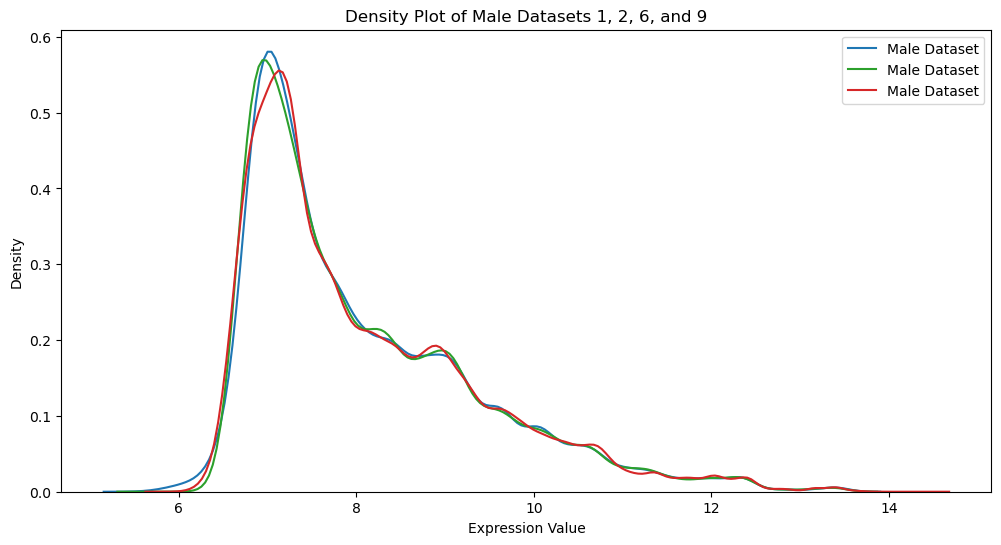

In [52]:
plt.figure(figsize=(12, 6))
for male_dataset in new_male_datasets:
    sns.kdeplot(male_dataset.values.flatten(), label='Male Dataset')
plt.xlabel('Expression Value')
plt.ylabel('Density')
plt.title('Density Plot of Male Datasets 1, 2, 6, and 9')
plt.legend()
plt.show()


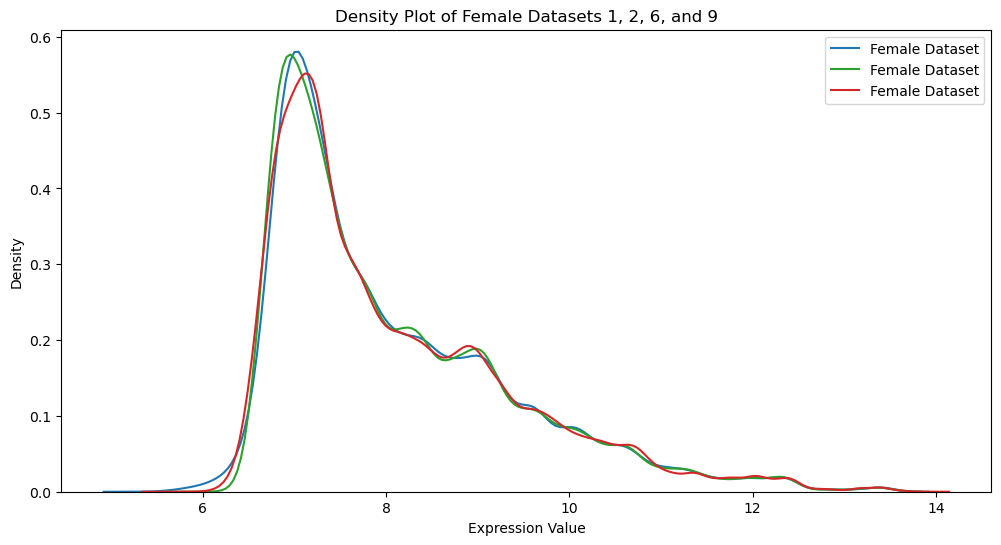

In [53]:
plt.figure(figsize=(12, 6))
for female_dataset in new_female_datasets:
    sns.kdeplot(female_dataset.values.flatten(), label='Female Dataset')
plt.xlabel('Expression Value')
plt.ylabel('Density')
plt.title('Density Plot of Female Datasets 1, 2, 6, and 9')
plt.legend()
plt.show()


## для 3 7 8 5 

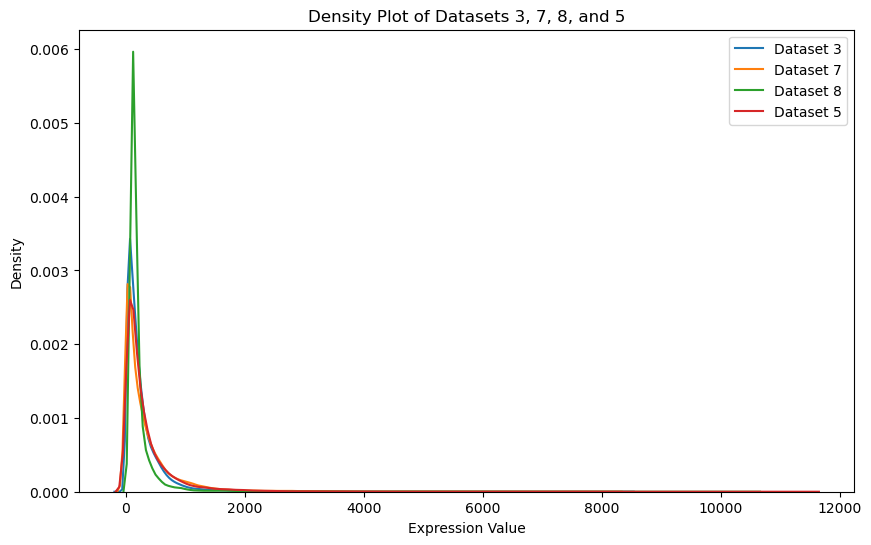

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

sns.kdeplot(datasets[2].values.flatten(), label='Dataset 3')
sns.kdeplot(datasets[6].values.flatten(), label='Dataset 7')
sns.kdeplot(datasets[7].values.flatten(), label='Dataset 8')
sns.kdeplot(datasets[4].values.flatten(), label='Dataset 5')

plt.xlabel('Expression Value')
plt.ylabel('Density')
plt.title('Density Plot of Datasets 3, 7, 8, and 5')

plt.legend()
plt.show()

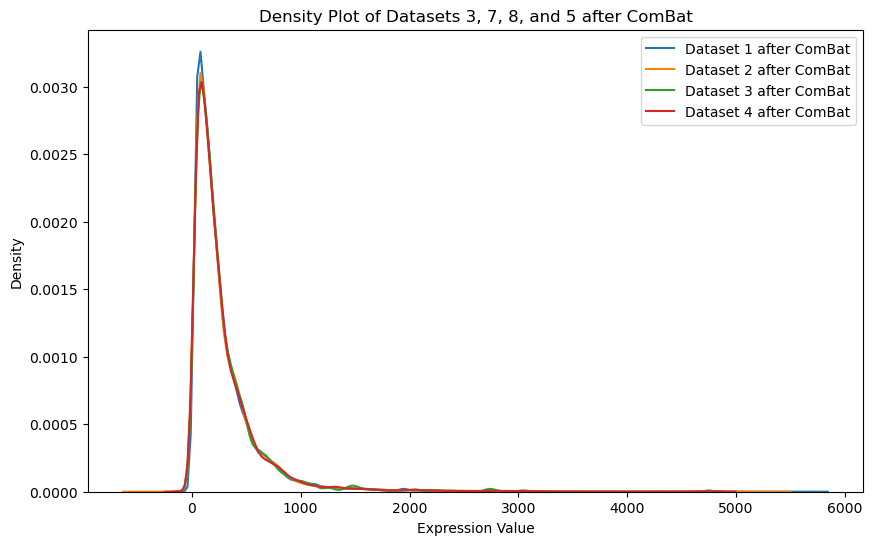

In [55]:
columns_3_7_8_5 = [datasets[i].columns[1:] for i in [2, 6, 7, 4]]

plt.figure(figsize=(10, 6))

datasets_corrected_3_7_8_5 = [df_corrected_combined_3_7_8_5.iloc[:, df_corrected_combined_3_7_8_5.columns.isin(columns)] for columns in columns_3_7_8_5]

for i, dataset_corrected in enumerate(datasets_corrected_3_7_8_5):
    sns.kdeplot(dataset_corrected.values.flatten(), label=f'Dataset {i+1} after ComBat')

plt.xlabel('Expression Value')
plt.ylabel('Density')
plt.title('Density Plot of Datasets 3, 7, 8, and 5 after ComBat')

plt.legend()

plt.show()


In [56]:
import pandas as pd

new2_male_datasets = []
new2_female_datasets = []

for dataset in datasets_corrected_3_7_8_5:
    male2_dataset = pd.DataFrame(columns=dataset.columns)
    female2_dataset = pd.DataFrame(columns=dataset.columns)

    column_names = dataset.columns[1:]  # Пропускаем первую колонку "ID_REF"

    for column in column_names:
        gsm_number = str(column.split('_')[-1])
        
        if (meta['GSM'] == gsm_number).any():
            gender = meta.loc[meta['GSM'] == gsm_number, 'sex'].iloc[0]

            if gender == 'M':
                male2_dataset[column] = dataset[column]
            elif gender == 'F':
                female2_dataset[column] = dataset[column]

    new2_male_datasets.append(male2_dataset)
    new2_female_datasets.append(female2_dataset)


In [57]:
print("Мужские датасеты:")
for i, dataset in enumerate(new2_male_datasets, 1):
    print(f"Мужской датасет {i}:")
    print("Форма датасета:", dataset.shape)  
    print("Первые пять строк датасета:")
    print(dataset.head())

print("\nЖенские датасеты:")
for i, dataset in enumerate(new2_female_datasets, 1):
    print(f"Женский датасет {i}:")
    print("Форма датасета:", dataset.shape)  
    print("Первые пять строк датасета:")
    print(dataset.head())


Мужские датасеты:
Мужской датасет 1:
Форма датасета: (1145, 498)
Первые пять строк датасета:
       GSM1350857  GSM1350858 GSM1350859  GSM1350860 GSM1350861 GSM1350862  \
ID_REF                                                                       
AAAS          NaN  374.207203        NaN  257.206450        NaN        NaN   
ABCB6         NaN   91.967985        NaN   96.941811        NaN        NaN   
ABCC5         NaN  120.442872        NaN  128.379222        NaN        NaN   
ABCC9         NaN   27.851002        NaN   31.567721        NaN        NaN   
ABCE1         NaN  454.102141        NaN  286.114260        NaN        NaN   

       GSM1350863 GSM1350864  GSM1350865  GSM1350866  ...  GSM1355855  \
ID_REF                                                ...               
AAAS          NaN        NaN  447.928697  398.621033  ...  310.639541   
ABCB6         NaN        NaN  105.935637   94.966608  ...   97.015151   
ABCC5         NaN        NaN  112.781892  108.390052  ...  132.90220

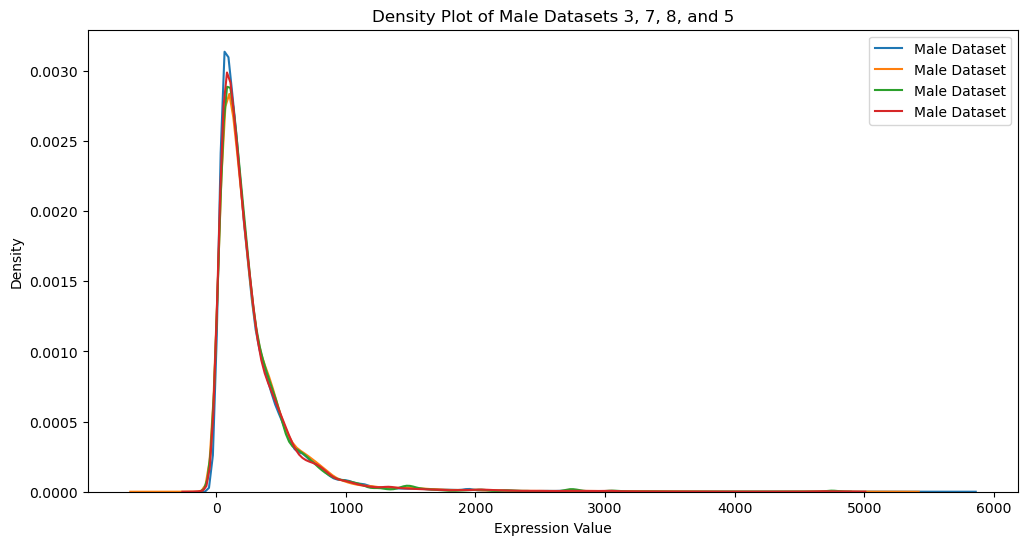

In [58]:
plt.figure(figsize=(12, 6))
for male2_dataset in new2_male_datasets:
    sns.kdeplot(male2_dataset.values.flatten(), label='Male Dataset')
plt.xlabel('Expression Value')
plt.ylabel('Density')
plt.title('Density Plot of Male Datasets 3, 7, 8, and 5')
plt.legend()
plt.show()


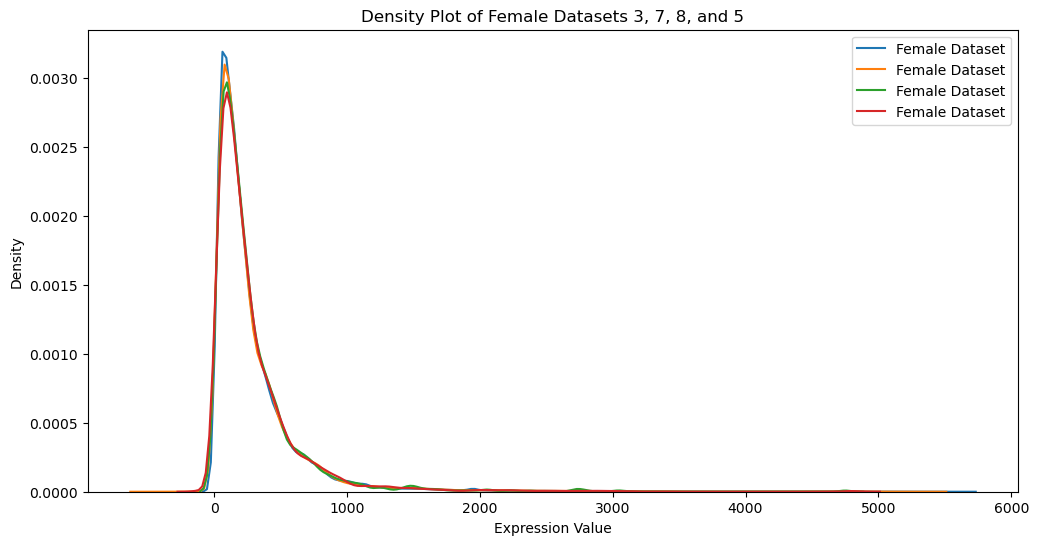

In [59]:
plt.figure(figsize=(12, 6))
for female2_dataset in new2_female_datasets:
    sns.kdeplot(female2_dataset.values.flatten(), label='Female Dataset')
plt.xlabel('Expression Value')
plt.ylabel('Density')
plt.title('Density Plot of Female Datasets 3, 7, 8, and 5')
plt.legend()
plt.show()


## Смотрим распределение по возрастам

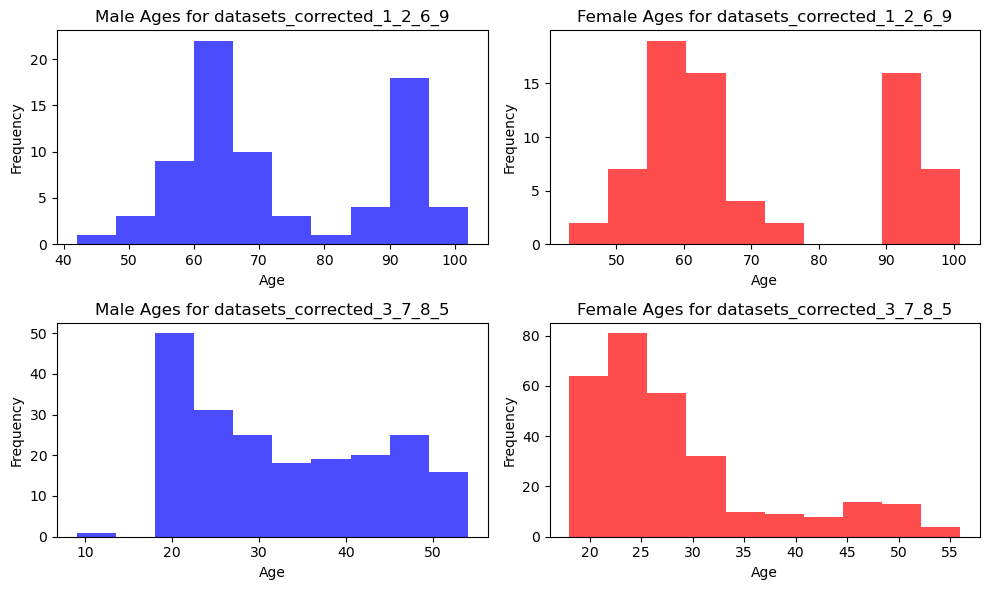

In [60]:

columns_1_2_6_9 = datasets_corrected_1_2_6_9[0].columns[1:]  
columns_3_7_8_5 = datasets_corrected_3_7_8_5[0].columns[1:]  

male_columns_1_2_6_9 = []
female_columns_1_2_6_9 = []
male_columns_3_7_8_5 = []
female_columns_3_7_8_5 = []

for column in columns_1_2_6_9:
    gsm_number = column.split('_')[-1]
    gender = meta.loc[meta['GSM'] == gsm_number, 'sex'].iloc[0]
    if gender == 'M':
        male_columns_1_2_6_9.append(column)
    elif gender == 'F':
        female_columns_1_2_6_9.append(column)

for column in columns_3_7_8_5:
    gsm_number = column.split('_')[-1]
    gender = meta.loc[meta['GSM'] == gsm_number, 'sex'].iloc[0]
    if gender == 'M':
        male_columns_3_7_8_5.append(column)
    elif gender == 'F':
        female_columns_3_7_8_5.append(column)

ages_male_1_2_6_9 = []
ages_female_1_2_6_9 = []
ages_male_3_7_8_5 = []
ages_female_3_7_8_5 = []

for column in male_columns_1_2_6_9:
    gsm_number = column.split('_')[-1]
    age = meta.loc[meta['GSM'] == gsm_number, 'age'].iloc[0]
    ages_male_1_2_6_9.append(age)

for column in female_columns_1_2_6_9:
    gsm_number = column.split('_')[-1]
    age = meta.loc[meta['GSM'] == gsm_number, 'age'].iloc[0]
    ages_female_1_2_6_9.append(age)

for column in male_columns_3_7_8_5:
    gsm_number = column.split('_')[-1]
    age = meta.loc[meta['GSM'] == gsm_number, 'age'].iloc[0]
    ages_male_3_7_8_5.append(age)

for column in female_columns_3_7_8_5:
    gsm_number = column.split('_')[-1]
    age = meta.loc[meta['GSM'] == gsm_number, 'age'].iloc[0]
    ages_female_3_7_8_5.append(age)


plt.figure(figsize=(10, 6))
plt.subplot(2, 2, 1)
plt.hist(ages_male_1_2_6_9, bins=10, color='blue', alpha=0.7)
plt.title('Male Ages for datasets_corrected_1_2_6_9')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(ages_female_1_2_6_9, bins=10, color='red', alpha=0.7)
plt.title('Female Ages for datasets_corrected_1_2_6_9')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.hist(ages_male_3_7_8_5, bins=10, color='blue', alpha=0.7)
plt.title('Male Ages for datasets_corrected_3_7_8_5')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.subplot(2, 2, 4)
plt.hist(ages_female_3_7_8_5, bins=10, color='red', alpha=0.7)
plt.title('Female Ages for datasets_corrected_3_7_8_5')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [ ]:
# Построить график распределения по значению по разным датасетам для M и F 
#По каждому датасету посмотреть суммарное распределение по возрастам 
#Посмотреть выбросы по плотности распределения 
*если ген встречается более 1 раз, надо подумать что делать с этим

# Разбиение объединения датасета 3_7_8_5 на два датасета согласно полу

In [75]:
male_columns = []
female_columns = []

for dataset in df_corrected_combined_3_7_8_5:
    column_names = dataset.columns[1:]  
    for column in column_names:
        gsm_number = str(column.split('_')[-1])
        
        if (meta['GSM'] == gsm_number).any():
            gender = meta.loc[meta['GSM'] == gsm_number, 'sex'].iloc[0]

            if gender == 'M':
                male_columns.append(column)
            elif gender == 'F':
                female_columns.append(column)

print("Columns for Males:", male_columns)
print("Columns for Females:", female_columns)

Columns for Males: ['GSM1350858', 'GSM1350860', 'GSM1350865', 'GSM1350866', 'GSM1350868', 'GSM1350869', 'GSM1350872', 'GSM1350873', 'GSM1350875', 'GSM1350880', 'GSM1350881', 'GSM1350883', 'GSM1350884', 'GSM1350885', 'GSM1350888', 'GSM1350889', 'GSM1350890', 'GSM1350891', 'GSM1350892', 'GSM1350893', 'GSM1350895', 'GSM1350897', 'GSM1350899', 'GSM1350902', 'GSM1350904', 'GSM1350905', 'GSM1350909', 'GSM1350916', 'GSM1350920', 'GSM1350923', 'GSM1350924', 'GSM1350930', 'GSM1350931', 'GSM1350937', 'GSM1350938', 'GSM1350946', 'GSM1350947', 'GSM1350949', 'GSM1350950', 'GSM1350951', 'GSM1350952', 'GSM1350953', 'GSM1350955', 'GSM1350956', 'GSM1350957', 'GSM1350963', 'GSM1350964', 'GSM1350969', 'GSM1350971', 'GSM1350973', 'GSM1350977', 'GSM1350979', 'GSM1350981', 'GSM1350982', 'GSM1350986', 'GSM1350988', 'GSM1350989', 'GSM1350990', 'GSM1350998', 'GSM1350999', 'GSM1351000', 'GSM1351001', 'GSM1351003', 'GSM1351004', 'GSM1351005', 'GSM1351006', 'GSM1351010', 'GSM1351015', 'GSM1351017', 'GSM1351018', 

In [87]:
male_dataset_3_7_8_5 = df_corrected_combined_3_7_8_5.loc[:, male_columns]
female_dataset_3_7_8_5 = df_corrected_combined_3_7_8_5.loc[:, female_columns]


In [89]:
female_dataset_3_7_8_5.head(2)

,GSM1350859,GSM1350861,GSM1350862,GSM1350863,GSM1350864,GSM1350867,GSM1350870,GSM1350871,GSM1350874,GSM1350876,...,GSM755468,GSM755472,GSM755474,GSM755475,GSM755476,GSM755478,GSM755481,GSM755482,GSM755484,GSM755485
ID_REF,,,,,,,,,,,,,,,,,,,,,
AAAS,543.951306,432.065194,411.710653,361.005942,303.413139,299.067921,439.168738,345.125297,310.998697,277.180459,...,415.780557,394.666494,413.079180,448.082397,391.181463,397.336015,459.881807,437.780212,394.883114,434.435347
ABCB6,90.970169,97.332480,92.056579,97.214265,87.342064,89.745593,98.477452,93.475298,88.792312,95.786761,...,91.117796,94.628753,90.862561,92.963254,93.209080,92.469250,91.367151,92.626861,91.738830,95.234496


In [90]:
male_dataset_3_7_8_5.head(2)

,GSM1350858,GSM1350860,GSM1350865,GSM1350866,GSM1350868,GSM1350869,GSM1350872,GSM1350873,GSM1350875,GSM1350880,...,GSM755469,GSM755470,GSM755471,GSM755473,GSM755477,GSM755479,GSM755480,GSM755483,GSM755486,GSM755487
ID_REF,,,,,,,,,,,,,,,,,,,,,
AAAS,374.207203,257.206450,447.928697,398.621033,322.590105,330.528999,397.574676,428.357442,204.923421,377.322358,...,443.163852,431.931477,397.559006,428.382734,409.428499,415.111584,500.032930,442.641416,400.910242,404.599151
ABCB6,91.967985,96.941811,105.935637,94.966608,82.008008,93.885442,78.824640,84.659408,97.450831,93.073666,...,91.827045,92.990306,93.207903,93.861871,89.177066,93.139684,92.076399,91.675315,93.823056,94.620520


In [91]:
male_dataset_3_7_8_5.to_csv("/SODA/data/RNA/raw_data/processed/male_dataset.csv")
female_dataset_3_7_8_5.to_csv("/SODA/data/RNA/raw_data/processed/female_dataset.csv")
